# News Category Classification using DistilBERT



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datset/query_result_2000.993493Z (1).parquet


# **IMPORTING ALL LIBRARIES**

In [2]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline
from transformers import TFTrainingArguments,TFTrainer
import tensorflow as tf
import pandas as pd
import json
import gc
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder() 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
import string
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot
import torch
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix
from datasets import load_dataset, load_metric
from collections import Counter
from wordcloud import WordCloud
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/c

**LOADING THE .parquet FILE USING PANDAS**

In [3]:
df = pd.read_parquet('/kaggle/input/datset/query_result_2000.993493Z (1).parquet')
df.head()

,title,paragraph,news_list,event_timestamp
0,Will the Covid-19 Grinch cancel a Santa rally ...,OPINION: Stock markets typically trade higher ...,"[""Supplier Market""]",2021-12-20T12:34:00Z
1,SPDR S&P XOP ETF In A Multi-Year Uptrend; Buy ...,SPDR S&P Oil & Gas Exploration & Production ET...,"[""Financial Health""]",2021-12-20T12:31:00Z
2,"Britain reports 10,000 new Omicron cases, ‘maj...",The total number of Omicron cases recorded acr...,"[""Environmental""]",2021-12-20T12:31:00Z
3,Risk aversion sentiment continues to percolate,- Risk aversion sentiment on rapid spread of t...,"[""Commodities""]",2021-12-20T12:30:00Z
4,Omicron rush on boosters may make it harder to...,Countries are saying three vaccine doses are n...,"[""Commodities""]",2021-12-20T12:16:00Z


# **Exploratory Data Analysis (EDA)**

In [4]:
df.shape

(2000, 4)

In [5]:
print(df.isnull().sum())

title              0
paragraph          0
news_list          0
event_timestamp    0
dtype: int64


In [6]:
print(df.describe())

                            title  \
count                        2000   
unique                       1970   
top     Twitter @PDChina #omicron   
freq                            7   

                                                paragraph          news_list  \
count                                                2000               2000   
unique                                               1944                  6   
top     Welcome to Tuesday, where Omicron now looms ov...  ["Environmental"]   
freq                                                    5                545   

             event_timestamp  
count                   2000  
unique                  1768  
top     2021-12-16T20:16:00Z  
freq                       4  


In [7]:
#Unique Categories of News
df['news_list'].unique()

array(['["Supplier Market"]', '["Financial Health"]', '["Environmental"]',
       '["Commodities"]', '["Compliance"]', '["Delays"]'], dtype=object)

news_list
["Environmental"]       545
["Commodities"]         506
["Delays"]              365
["Financial Health"]    303
["Compliance"]          160
["Supplier Market"]     121
Name: title, dtype: int64


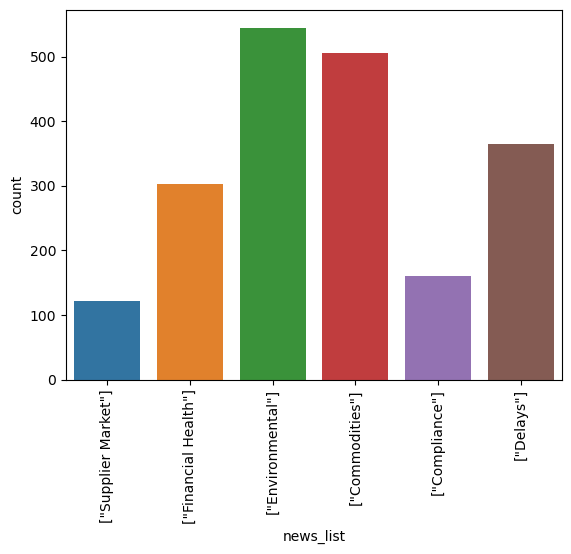

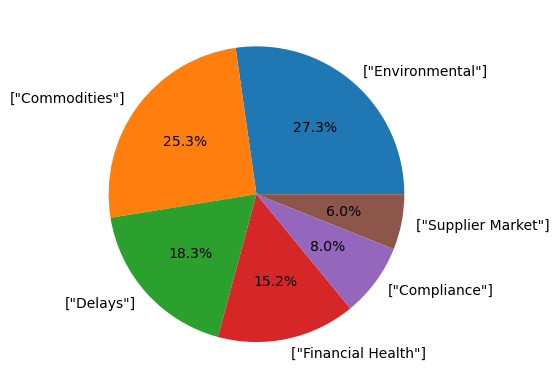

In [8]:
# Count of News belonging to each category
print(df.groupby("news_list")["title"].count().sort_values(ascending=False))
sns.countplot(x="news_list", data=df)
plt.xticks(rotation=90)
plt.show()
plt.pie(df["news_list"].value_counts(), labels=df["news_list"].value_counts().index, autopct="%1.1f%%")
plt.show()

news_list
["Commodities"]         68.247036
["Compliance"]          69.787500
["Delays"]              72.194521
["Environmental"]       70.130275
["Financial Health"]    69.049505
["Supplier Market"]     66.239669
Name: title_length, dtype: float64


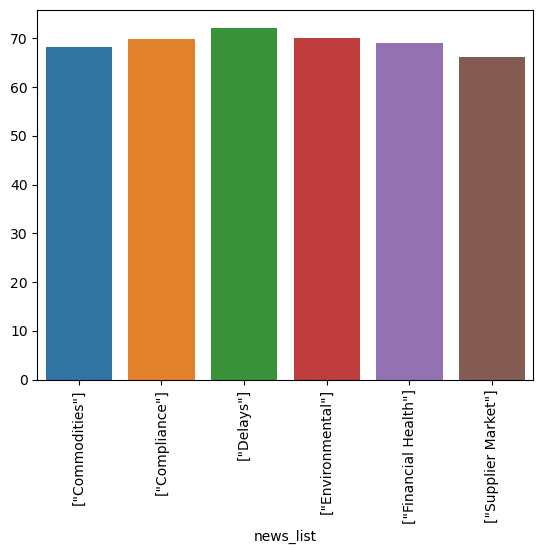

In [9]:
#AVERAGE LENGTH OF TITLE FOR EACH CATEGORY
df["title_length"] = df["title"].str.len()
print(df.groupby("news_list")["title_length"].mean())
sns.barplot(x=df.groupby("news_list")["title_length"].mean().index, y=df.groupby("news_list")["title_length"].mean().values)
plt.xticks(rotation=90)
plt.show()

news_list
["Commodities"]         224.391304
["Compliance"]          222.456250
["Delays"]              316.769863
["Environmental"]       206.372477
["Financial Health"]    204.306931
["Supplier Market"]     238.578512
Name: paragraph_length, dtype: float64


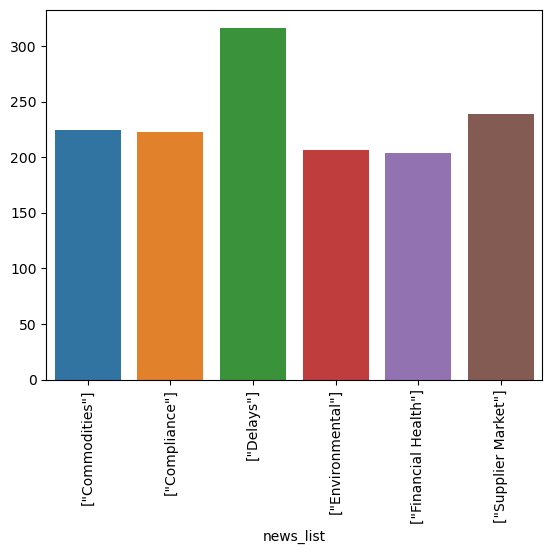

In [10]:
#AVERAGE LENGTH OF PARAGRAPH FOR EACH CATEGORY
df["paragraph_length"] = df["paragraph"].str.len()
print(df.groupby("news_list")["paragraph_length"].mean())
sns.barplot(x=df.groupby("news_list")["paragraph_length"].mean().index, y=df.groupby("news_list")["paragraph_length"].mean().values)
plt.xticks(rotation=90)
plt.show()

In [11]:
#The number of paragraphs that contain a link
mask = df["paragraph"].str.contains(r"https?://\S+")
num_link = mask.sum()
print(num_link)

1


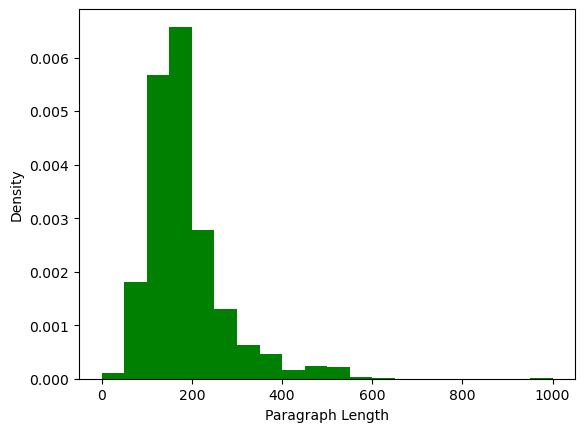

In [12]:
#Density of News vs Paragraph Length
plt.hist(df["paragraph_length"], bins=20, color="green", range=(0, 1000), density=True)
plt.xlabel("Paragraph Length")
plt.ylabel("Density")
plt.show()

# **Preprocessing of Data**

In [13]:
#Combining title and paragraph column into text
df['text'] = df['title'] + ' ' + df['paragraph']

In [14]:
#Removing stopwords, punctuators and performing lemmatization
def remove_stopwords_and_punctuations(text):
    stop_words = set(stopwords.words('english'))
    translator = str.maketrans('', '', string.punctuation)
    lemmatizer = WordNetLemmatizer()

    words = nltk.word_tokenize(text)
    words = [word for word in words if word.lower() not in stop_words]

    # Lemmatize the words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    words_without_punctuations = [word.translate(translator) for word in lemmatized_words]
    words_preprocessed = [word.replace("‘", "").replace("’", "") for word in words_without_punctuations]
    return ' '.join(words_preprocessed)
df['text'] = df['text'].apply(remove_stopwords_and_punctuations)

In [15]:
print(df['text'][2])

Britain report 10000 new Omicron case   major incident  declared London  National total number Omicron case recorded across country hit almost 25000 1800 GMT Friday  10000 case 24 hour earlier 


In [16]:
#Encode for News Categories
encoder = LabelEncoder() 
df['encoded_labels'] = encoder.fit_transform(df['news_list'])

In [17]:
encoder.inverse_transform([[0],[1],[2],[3],[4],[5]])

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



array(['["Commodities"]', '["Compliance"]', '["Delays"]',
       '["Environmental"]', '["Financial Health"]', '["Supplier Market"]'],
      dtype=object)

In [18]:
def tokenize_text(text):
    return text.split()  # Modify this function if you have more complex tokenization requirements

df['tokenized_text'] = df['text'].apply(tokenize_text)

# Create a function to count the occurrences of words in each category
def count_top_words_by_category(category_list):
    all_words = [word for words in category_list for word in words]
    word_counts = Counter(all_words)
    return word_counts.most_common(10)

# Group the DataFrame by 'news_list' (category) and apply the count_top_words_by_category function
top_words_by_category = df.groupby('news_list')['tokenized_text'].apply(count_top_words_by_category).reset_index()

# Display the top 10 words for each category
for idx, row in top_words_by_category.iterrows():
    category = row['news_list']
    top_words = row['tokenized_text']
    print(f"Category: {category}")
    print(f"Top 10 words and their count:")
    for word, count in top_words:
        print(f"{word}: {count}")
    print()

Category: ["Commodities"]
Top 10 words and their count:
Omicron: 694
variant: 591
omicron: 327
case: 308
COVID19: 214
new: 135
s: 128
said: 111
spread: 99
first: 86

Category: ["Compliance"]
Top 10 words and their count:
Omicron: 213
variant: 118
spread: 49
travel: 43
omicron: 43
case: 36
coronavirus: 32
COVID19: 32
s: 31
new: 28

Category: ["Delays"]
Top 10 words and their count:
Omicron: 523
variant: 397
case: 295
new: 205
omicron: 167
infection: 151
COVID19: 144
coronavirus: 114
said: 89
s: 86

Category: ["Environmental"]
Top 10 words and their count:
Omicron: 657
variant: 607
case: 390
omicron: 384
COVID19: 212
coronavirus: 163
new: 136
s: 130
said: 118
say: 106

Category: ["Financial Health"]
Top 10 words and their count:
Omicron: 432
variant: 320
omicron: 136
case: 132
COVID19: 84
new: 80
lockdown: 65
s: 65
Covid: 52
Pfizer: 51

Category: ["Supplier Market"]
Top 10 words and their count:
Omicron: 159
variant: 80
price: 60
demand: 45
oil: 44
omicron: 43
Oil: 39
market: 35
case: 31

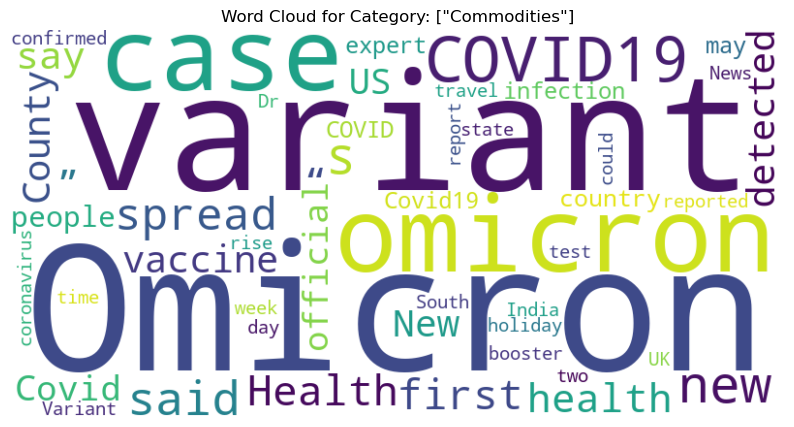

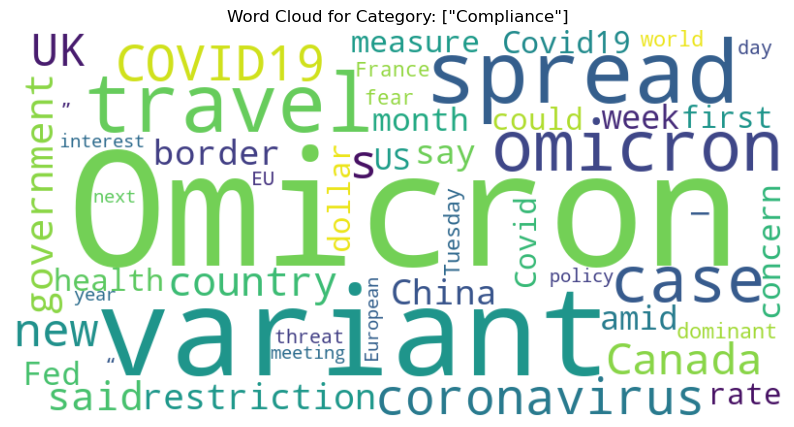

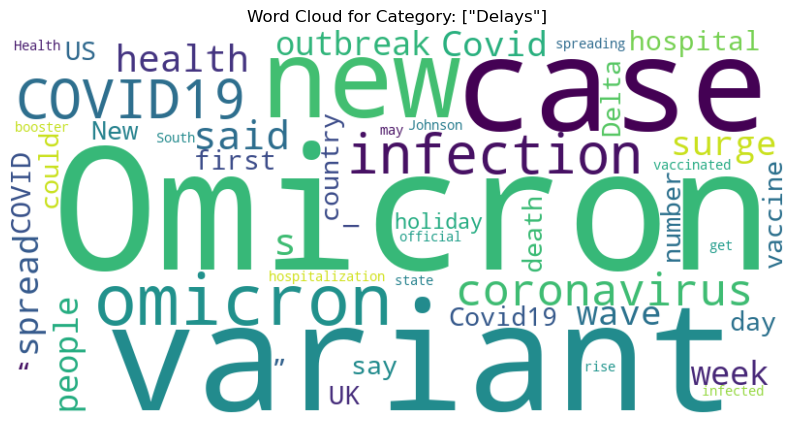

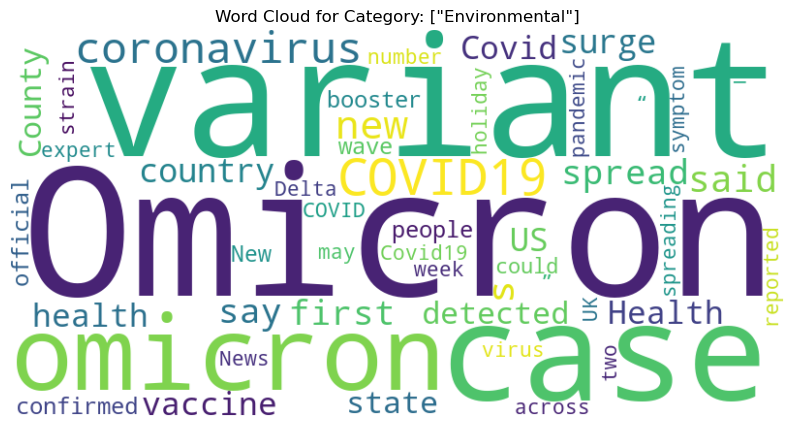

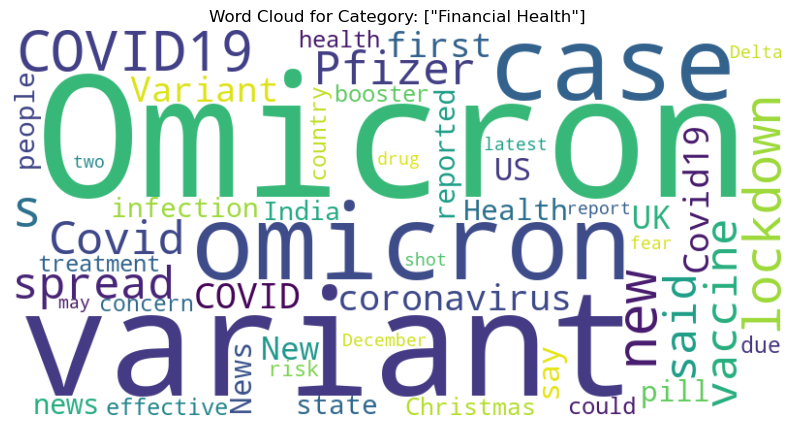

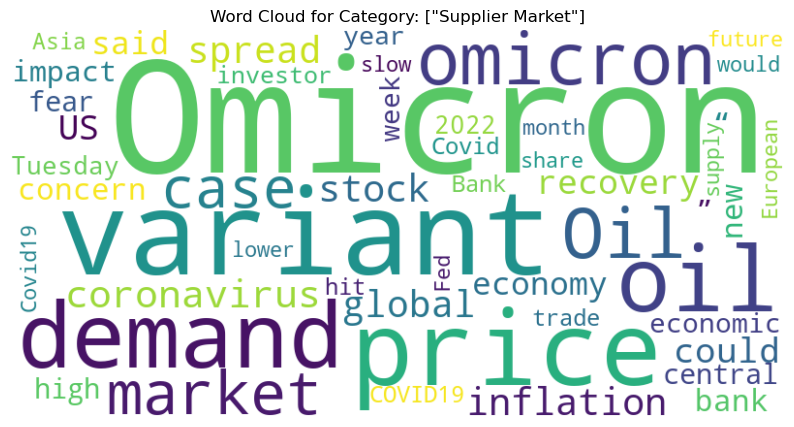

In [19]:

from wordcloud import WordCloud

# Create a function to count the occurrences of words in each category
def count_top_words_by_category(category_list):
    all_words = [word for words in category_list for word in words]
    word_counts = Counter(all_words)
    return word_counts.most_common(50)  # Modify this to return the top 50 words

# Group the DataFrame by 'news_list' (category) and apply the count_top_words_by_category function
top_words_by_category = df.groupby('news_list')['tokenized_text'].apply(count_top_words_by_category).reset_index()

# Create word maps for each category
for idx, row in top_words_by_category.iterrows():
    category = row['news_list']
    top_words = row['tokenized_text']
    
    # Create a dictionary from the top_words list
    word_freq_dict = dict(top_words)
    
    # Generate word cloud for the current category
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate_from_frequencies(word_freq_dict)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Category: {category}")
    plt.axis('off')
    plt.show()


**We found the most categories contain the word Omicron- 'A Covid Variant'. We deduce the fact that the supplier chain market was most affected by Covid.**

In [20]:
df.head()

,title,paragraph,news_list,event_timestamp,title_length,paragraph_length,text,encoded_labels,tokenized_text
0,Will the Covid-19 Grinch cancel a Santa rally ...,OPINION: Stock markets typically trade higher ...,"[""Supplier Market""]",2021-12-20T12:34:00Z,67,161,Covid19 Grinch cancel Santa rally stock market...,5,"[Covid19, Grinch, cancel, Santa, rally, stock,..."
1,SPDR S&P XOP ETF In A Multi-Year Uptrend; Buy ...,SPDR S&P Oil & Gas Exploration & Production ET...,"[""Financial Health""]",2021-12-20T12:31:00Z,54,160,SPDR P XOP ETF MultiYear Uptrend Buy Dips SP...,4,"[SPDR, P, XOP, ETF, MultiYear, Uptrend, Buy, D..."
2,"Britain reports 10,000 new Omicron cases, ‘maj...",The total number of Omicron cases recorded acr...,"[""Environmental""]",2021-12-20T12:31:00Z,88,157,Britain report 10000 new Omicron case major ...,3,"[Britain, report, 10000, new, Omicron, case, m..."
3,Risk aversion sentiment continues to percolate,- Risk aversion sentiment on rapid spread of t...,"[""Commodities""]",2021-12-20T12:30:00Z,46,150,Risk aversion sentiment continues percolate R...,0,"[Risk, aversion, sentiment, continues, percola..."
4,Omicron rush on boosters may make it harder to...,Countries are saying three vaccine doses are n...,"[""Commodities""]",2021-12-20T12:16:00Z,78,148,Omicron rush booster may make harder stop rise...,0,"[Omicron, rush, booster, may, make, harder, st..."


In [21]:
X = df['text'].to_list()
Y = df['encoded_labels'].to_list()

**Splitting Data into Train,Test,Validation Dataset**

In [22]:
# Split data into training (75%) and combined testing + validation (25%)
train_texts, combined_texts, train_labels, combined_labels = train_test_split(X, Y, test_size=0.25, shuffle = True,random_state=42)

# Split the combined testing + validation data into testing (10%) and validation (15%)
test_texts, val_texts, test_labels, val_labels = train_test_split(combined_texts, combined_labels, test_size=0.70, random_state=42)

# Ratios- Train Set-80%, Test Set-10%, Validation Set-10%

# **DistilBERT**

 **I chose DistilBERT for finetuning and transfer learning for my task due to several compelling reasons that make it the preferred choice over BERT, RoBERTa, and XLNet, especially considering the limited training time:**

    1. Faster Inference Speed:DistilBERT offers faster inference speed compared to BERT, RoBERTa, and XLNet. This is a critical advantage for my task, as it involves real-time or low-latency processing. The faster inference speed of DistilBERT ensures that I can obtain results quickly and efficiently.

    2. Efficient Resource Utilization: DistilBERT is a smaller network that retains 95% of BERT's language understanding capabilities while using 60% fewer parameters. This parameter efficiency makes it more suitable for tasks with limited computational resources, enabling me to achieve comparable performance with reduced memory and computational requirements.

    3. Acceptable Trade-off in Prediction Metrics: While DistilBERT may have a slight compromise on prediction metrics compared to BERT, RoBERTa, and XLNet, the difference in performance is minor. Given the gains in inference speed and resource efficiency, this trade-off is well justified for my task.

    4. Transfer Learning Benefits: DistilBERT benefits from pretraining on a large corpus, which provides it with a strong language understanding foundation. This makes it well-suited for transfer learning, allowing me to fine-tune the model on my specific task with potentially less labeled data.

    5. Training Time Limitation: Since I have limited training time, DistilBERT's faster training speed compared to BERT, RoBERTa, and XLNet becomes a crucial factor. It allows me to efficiently fine-tune the model within my time constraints while still achieving satisfactory performance.

**Considering these reasons, DistilBERT emerges as the most practical and efficient choice for my task. Its faster inference, resource efficiency, and transfer learning benefits make it well-suited to meet the requirements and constraints of my specific scenario, especially when training time is limited.**

In [23]:
#Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [24]:
#SENTENCE WITH MAX LENGTH IN ALL DATASETS
max_len = 0
for row in train_texts :
    max_len = max(max_len, len(tokenizer.encode(row)))
print(f"Max sentence length (train): {max_len}")

max_len = 0
for row in val_texts:
    max_len = max(max_len, len(tokenizer.encode(row)))
print(f"Max sentence length (val): {max_len}")
max_len = 0
for row in test_texts:
    max_len = max(max_len, len(tokenizer.encode(row)))
print(f"Max sentence length (test): {max_len}")

Token indices sequence length is longer than the specified maximum sequence length for this model (635 > 512). Running this sequence through the model will result in indexing errors


Max sentence length (train): 1321
Max sentence length (val): 816
Max sentence length (test): 443


In [25]:
#Transformation of Labels and Encodings
train_encodings = tokenizer(train_texts, truncation = True, padding = True  )

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

test_encodings= tokenizer(test_texts, truncation = True, padding = True )

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

test_dataset = tf.data.Dataset.from_tensor_slices(
    (dict(test_encodings), test_labels)
)

**Fine-Tuning and Training**

In [26]:
model=TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 6 )
metric = load_metric("accuracy")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [27]:
from transformers import TFTrainingArguments,TFTrainer
training_args = TFTrainingArguments(
    output_dir='/kaggle/working/results',          
    num_train_epochs=8,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=1e-5,               
    logging_dir='/kaggle/working/logs',            
    eval_steps=100                   
)
def compute_metrics(eval_pred):
   

    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 6 )
trainer = TFTrainer(
    model=trainer_model,                 
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset, 
    compute_metrics=compute_metrics,
    
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [28]:
print(trainer)

In [29]:
trainer.train()

In [30]:
trainer.evaluate()

{'eval_loss': 1.391334851582845, 'eval_accuracy': 0.5651041666666666}

In [31]:
#Saving the tokenizer and model
save_directory = "./saved_models" 

trainer.save_model(save_directory)

tokenizer.save_pretrained(save_directory)



('./saved_models/tokenizer_config.json',
 './saved_models/special_tokens_map.json',
 './saved_models/vocab.txt',
 './saved_models/added_tokens.json')

In [32]:
#Loading the saved tokenizer and model
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)

model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at ./saved_models were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./saved_models and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Measurement of Predictions**

In [33]:
preds, label_ids, metrics = trainer.predict(test_dataset)
preds[:5]

array([[-0.7238524 ,  2.929655  , -1.3515792 , -1.4462847 , -0.44248194,
         0.6542576 ],
       [-0.81321615, -1.2583703 ,  3.9451735 , -1.0706909 , -0.03597738,
        -0.9895526 ],
       [ 0.06654881, -1.237241  ,  0.01186088,  4.2088156 , -1.1306915 ,
        -2.2857356 ],
       [ 3.9446895 , -1.0867404 , -1.9610575 ,  0.19221786, -0.3679941 ,
        -2.0697446 ],
       [-1.4092587 , -0.97432554,  3.5122604 ,  1.6387142 , -1.1016157 ,
        -1.653343  ]], dtype=float32)

In [34]:
print(f"Test dataset size: {len(test_labels)}")
print(f" Predictions size: {len(preds)}")

Test dataset size: 150
 Predictions size: 150


In [35]:
print(f"Test dataset size: {len(val_labels)}")
print(f" Predictions size: {len(preds)}")

Test dataset size: 350
 Predictions size: 150


In [36]:
preds = np.argmax(preds, axis=1)
preds

array([1, 2, 3, 0, 2, 0, 2, 2, 3, 4, 2, 4, 2, 1, 4, 4, 3, 3, 0, 0, 3, 3,
       3, 2, 5, 3, 4, 3, 0, 4, 5, 2, 4, 4, 3, 0, 2, 1, 2, 4, 3, 0, 2, 3,
       0, 1, 0, 0, 3, 1, 0, 5, 1, 0, 3, 3, 0, 3, 4, 1, 3, 0, 3, 4, 4, 0,
       3, 3, 5, 2, 0, 0, 3, 0, 0, 4, 0, 1, 2, 3, 3, 0, 3, 5, 3, 3, 0, 4,
       3, 2, 2, 3, 2, 4, 3, 0, 0, 1, 0, 3, 1, 3, 5, 0, 3, 2, 1, 1, 0, 0,
       0, 1, 0, 4, 3, 4, 0, 3, 2, 0, 3, 3, 3, 0, 0, 3, 0, 0, 3, 2, 2, 2,
       1, 0, 4, 3, 1, 2, 1, 0, 4, 3, 3, 0, 2, 2, 3, 0, 3, 1])

Text(0.5, 14.722222222222216, 'Prediction')

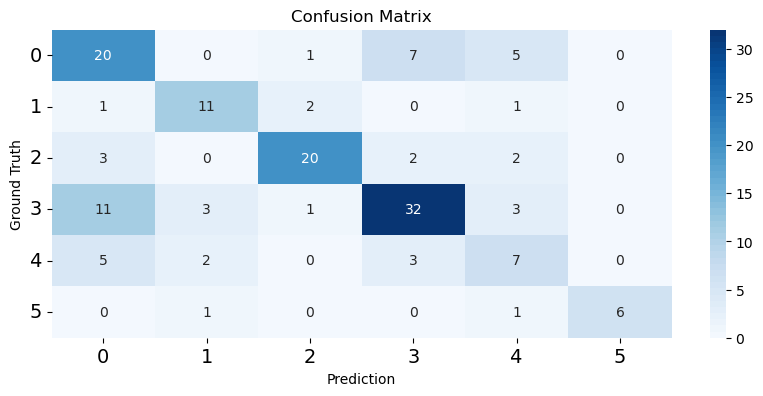

In [37]:
plt.figure(figsize=(10, 4))

heatmap = sns.heatmap(
    data=pd.DataFrame(confusion_matrix(test_labels, preds)),
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues", 50),
)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), fontsize=14)
heatmap.yaxis.set_ticklabels(
    heatmap.yaxis.get_ticklabels(), rotation=0, fontsize=14
)

plt.title("Confusion Matrix")
plt.ylabel("Ground Truth")
plt.xlabel("Prediction")

Precision, recall, accuracy and F1 score are common metrics used to evaluate the performance of multiclass classification models. Each metric has a different rationale and interpretation.

**1. Precision** is the ratio of true positives to the total number of predicted positives. It measures how accurate the model is in identifying the correct class for each instance. A high precision means that the model has a low rate of false positives, or misclassifying instances as belonging to a class when they do not.

**2. Recall** is the ratio of true positives to the total number of actual positives. It measures how sensitive the model is in detecting all the instances that belong to a class. A high recall means that the model has a low rate of false negatives, or missing instances that should have been classified as belonging to a class.

**3. Accuracy** is the ratio of correct predictions to the total number of predictions. It measures how well the model performs overall, regardless of the class distribution. A high accuracy means that the model has a low rate of errors, or misclassifying instances as belonging to any class.

**4. F1 score** is the harmonic mean of precision and recall. It measures how balanced the model is in terms of both accuracy and sensitivity. A high F1 score means that the model has a good trade-off between precision and recall, or minimizing both false positives and false negatives.

In [38]:
#'micro':Calculate metrics globally by counting the total true positives, false negatives and false positives.
print(f"Precision: {precision_score(test_labels, preds, average='micro') * 100:.3f}%")
print(f"   Recall: {recall_score(test_labels, preds, average='micro') * 100 :.3f}%")
print(f" Accuracy: {accuracy_score(test_labels, preds) * 100:.3f}%")
print(f"   F1Score: {f1_score(test_labels, preds, average='micro') * 100 :.3f}%")

Precision: 64.000%
   Recall: 64.000%
 Accuracy: 64.000%
   F1Score: 64.000%


In [39]:
#'weighted':Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
print(f"Precision: {precision_score(test_labels, preds, average='weighted') * 100:.3f}%")
print(f"   Recall: {recall_score(test_labels, preds, average='weighted') * 100 :.3f}%")
print(f" Accuracy: {accuracy_score(test_labels, preds) * 100:.3f}%")
print(f"   F1Score: {f1_score(test_labels, preds, average='weighted') * 100 :.3f}%")

Precision: 66.222%
   Recall: 64.000%
 Accuracy: 64.000%
   F1Score: 64.721%


In [40]:
#'macro':Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
print(f"Precision: {precision_score(test_labels, preds, average='macro') * 100:.3f}%")
print(f"   Recall: {recall_score(test_labels, preds, average='macro') * 100 :.3f}%")
print(f" Accuracy: {accuracy_score(test_labels, preds) * 100:.3f}%")
print(f"   F1Score: {f1_score(test_labels, preds, average='macro') * 100 :.3f}%")

Precision: 67.935%
   Recall: 64.698%
 Accuracy: 64.000%
   F1Score: 65.777%


# **Prediction for User Data**

In [41]:
def prediction(textinput):
    
    def remove_stopwords_and_punctuations(text):
        stop_words = set(stopwords.words('english'))
        translator = str.maketrans('', '', string.punctuation)
        lemmatizer = WordNetLemmatizer()

        words = nltk.word_tokenize(text)
        words = [word for word in words if word.lower() not in stop_words]

        # Lemmatize the words
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

        words_without_punctuations = [word.translate(translator) for word in lemmatized_words]
        return ' '.join(words_without_punctuations)
    textinput=remove_stopwords_and_punctuations(textinput)
    predict_input = tokenizer_fine_tuned.encode(
        textinput,
        truncation = True,
        padding = True,
        return_tensors = 'tf'    
    )
    
    output = model_fine_tuned(predict_input)[0]
    print(output)
    prediction_value = tf.argmax(output, axis = 1).numpy()[0]

    return encoder.inverse_transform([prediction_value])

In [53]:
title=input("Enter the News Title")
paragraph=input("Enter the News Paragraph")
text=title+' '+ paragraph
print(prediction(text))

Enter the News Title S&P 500 slips to kick off August, Dow notches small gain after touching highest level in over a year
Enter the News Paragraph The S&P 500  fell to start August, as investors navigated a raft of corporate earnings reports and assessed a fresh batch of economic data.  The broad-based index lost 0.27% to finish at 4,576.73, while the Nasdaq Composite  dropped 0.43% to end at 14,283.91. The Dow Jones Industrial Average  added 71.15 points, or 0.2%, to settle at 35,630.68. Earlier in the session, the Dow touched its highest level since February 2022.  Pharmaceutical giant Merck  pulled back 1.3% even after reporting a smaller-than-expected loss and revenue that exceeded expectations, thanks to strong Keytruda sales. Caterpillar  posted strong results, boosting shares 8.9%.


tf.Tensor([[-0.5544941   0.21024476 -1.7800791  -1.8028651   0.6067978   2.7647316 ]], shape=(1, 6), dtype=float32)
['["Supplier Market"]']
